### Problem Statement

It is a critical requirement for business to understand the value derived from a customer. RFM is a method used for analyzing customer value.
Customer segmentation is the practice of segregating the customer base into groups of individuals based on some common characteristics such as age, gender, interests, and spending habits
Perform customer segmentation using RFM analysis. The resulting segments can be ordered from most valuable (highest recency, frequency, and value) to least valuable (lowest recency, frequency, and value).

### Dataset Description

This is a transnational data set which contains all the transactions that occurred between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique and all-occasion gifts.

1. InvoiceNo - 	Invoice number. Nominal, a six digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation
2. StockCode -	Product (item) code. Nominal, a five digit integral number uniquely assigned to each distinct product
3. Description -	Product (item) name. Nominal
4. Quantity -	The quantities of each product (item) per transaction. Numeric
5. InvoiceDate -	Invoice Date and time. Numeric, the day and time when each transaction was generated
6. UnitPrice -	Unit price. Numeric, product price per unit in sterling
7. CustomerID -	Customer number. Nominal, a six digit integral number uniquely assigned to each customer
8. Country -	Country name. Nominal, the name of the country where each customer resides

In [1]:
#import the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from operator import attrgetter
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
#read the data and display top 5 rows

data = pd.read_excel('Online Retail.xlsx')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
#check number of rows and attributes in data

data.shape

(541909, 8)

In [4]:
#remove duplicate values from data

data = data.drop_duplicates()

In [5]:
#check for missing values

missing = pd.Series(data.isnull().sum())
missing[missing != 0]

Description      1454
CustomerID     135037
dtype: int64

We have lot of missing customer ids, which we will remove. We don't need product description for analysis, so we will let those missing values be.

In [6]:
data.dropna(subset=['CustomerID'],inplace=True)

In [7]:
#check shape of data after removing null and duplicate values

data.shape

(401604, 8)

In [8]:
#describe the data

data.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


We see that there are some negative values in Quantity, which is a wrong entry. We will take values greater than 0.

In [9]:
data = data[data['Quantity']>0]

Let us check number of unique values for each variable.

In [10]:
print('Number of transactions',data['InvoiceNo'].nunique())
print('Number of products bought',data['StockCode'].nunique())
print('Number of customers',data['CustomerID'].nunique())
print('Number of countries',data['Country'].nunique())

Number of transactions 18536
Number of products bought 3665
Number of customers 4339
Number of countries 37


In [11]:
#Number of unique customers from each country

country_data = data[['CustomerID','Country']].drop_duplicates()
country_data.Country.value_counts()

United Kingdom          3921
Germany                   94
France                    87
Spain                     30
Belgium                   25
Switzerland               21
Portugal                  19
Italy                     14
Finland                   12
Austria                   11
Norway                    10
Netherlands                9
Denmark                    9
Australia                  9
Channel Islands            9
Cyprus                     8
Sweden                     8
Japan                      8
Poland                     6
Unspecified                4
Greece                     4
Canada                     4
USA                        4
Israel                     3
EIRE                       3
United Arab Emirates       2
Malta                      2
Bahrain                    2
Saudi Arabia               1
Czech Republic             1
Singapore                  1
RSA                        1
Lithuania                  1
Lebanon                    1
Iceland       

Since most customers are from UK, and the segments will vary for different regions, we will only focus on UK data.

In [12]:
data = data[data['Country']=='United Kingdom']

Now we will create month cohorts and analyse retention rate. 

Let us keep only the required columns and remove duplicates as they indicate different items of same purchase.

In [13]:
df_cohort = data[['CustomerID', 'InvoiceNo', 'InvoiceDate']].drop_duplicates()

We will define a column order_month which indicates the month in which order is made and a column for the month in which customer made their first purchase. This will be used to create cohorts.

In [14]:
df_cohort['order_month'] = df_cohort['InvoiceDate'].dt.to_period('M')
df_cohort['cohort'] = df_cohort.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M') 

In [15]:
df_cohort.head()

,CustomerID,InvoiceNo,InvoiceDate,order_month,cohort
0,17850.0,536365,2010-12-01 08:26:00,2010-12,2010-12
7,17850.0,536366,2010-12-01 08:28:00,2010-12,2010-12
9,13047.0,536367,2010-12-01 08:34:00,2010-12,2010-12
21,13047.0,536368,2010-12-01 08:34:00,2010-12,2010-12
25,13047.0,536369,2010-12-01 08:35:00,2010-12,2010-12


Now we will group the data by cohorts and then by the various months in which each cohort has made orders. This will help us analyse each cohort's behaviour over time. We will also calculate numbers of months passed for each transactions since first purchase.

In [16]:
df_cohort = df_cohort.groupby(['cohort', 'order_month']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [17]:
df_cohort.head()

,cohort,order_month,n_customers,period_number
0,2010-12,2010-12,815,0
1,2010-12,2011-01,289,1
2,2010-12,2011-02,263,2
3,2010-12,2011-03,304,3
4,2010-12,2011-04,293,4


Let us create a pivot table with cohorts in rows and number of months passed in columns. 

In [18]:
pivot = df_cohort.pivot_table(index = 'cohort',columns = 'period_number',values = 'n_customers')
pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,815.0,289.0,263.0,304.0,293.0,323.0,291.0,278.0,289.0,325.0,299.0,405.0,218.0
2011-01,358.0,76.0,93.0,84.0,119.0,99.0,90.0,87.0,108.0,117.0,127.0,43.0,NaN
2011-02,340.0,64.0,66.0,97.0,98.0,86.0,87.0,96.0,90.0,104.0,25.0,NaN,NaN
2011-03,419.0,64.0,109.0,83.0,94.0,69.0,111.0,96.0,119.0,38.0,NaN,NaN,NaN
2011-04,277.0,58.0,56.0,60.0,56.0,61.0,61.0,73.0,20.0,NaN,NaN,NaN,NaN
2011-05,256.0,48.0,44.0,44.0,53.0,58.0,68.0,23.0,NaN,NaN,NaN,NaN,NaN
2011-06,214.0,38.0,31.0,51.0,51.0,69.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,169.0,30.0,33.0,39.0,47.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,141.0,32.0,32.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We will now divide the values in pivot table with number of customers in the starting month of each cohort to calculate retention rate.

In [19]:
size = pivot.iloc[:,0]
retention_matrix = pivot.divide(size, axis = 0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2010-12,1.0,0.354601,0.322699,0.373006,0.359509,0.396319,0.357055,0.341104,0.354601,0.398773,0.366871,0.496933,0.267485
2011-01,1.0,0.212291,0.259777,0.234637,0.332402,0.276536,0.251397,0.243017,0.301676,0.326816,0.354749,0.120112,NaN
2011-02,1.0,0.188235,0.194118,0.285294,0.288235,0.252941,0.255882,0.282353,0.264706,0.305882,0.073529,NaN,NaN
2011-03,1.0,0.152745,0.260143,0.198091,0.224344,0.164678,0.264916,0.229117,0.284010,0.090692,NaN,NaN,NaN
2011-04,1.0,0.209386,0.202166,0.216606,0.202166,0.220217,0.220217,0.263538,0.072202,NaN,NaN,NaN,NaN
2011-05,1.0,0.187500,0.171875,0.171875,0.207031,0.226562,0.265625,0.089844,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.177570,0.144860,0.238318,0.238318,0.322430,0.098131,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.177515,0.195266,0.230769,0.278107,0.106509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.226950,0.226950,0.241135,0.120567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


This matrix gives retention rate of each cohort with number of months passed since their first purchase. Null values indicate that we do not have data after Dec 2011. Let us visualize it in a heatmap.

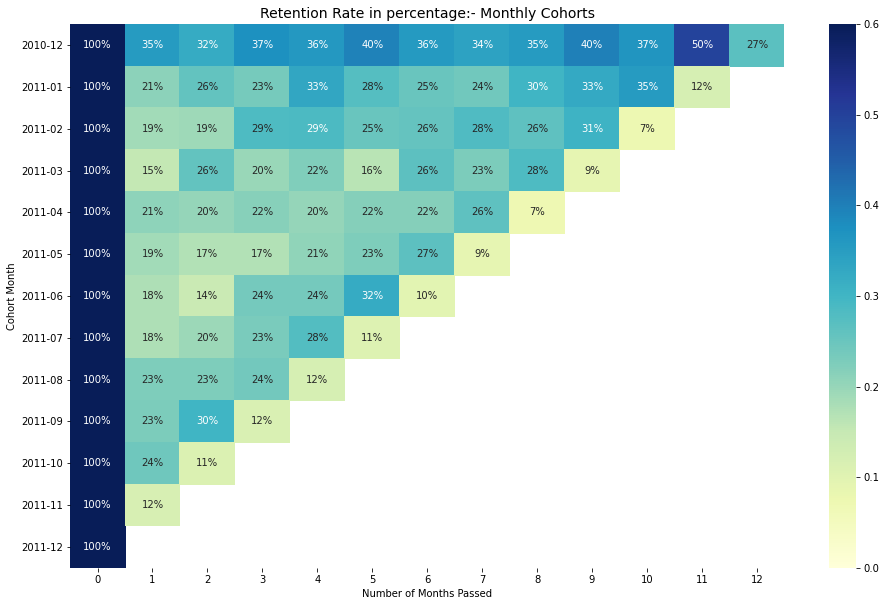

In [20]:
plt.figure(figsize=(16, 10))

plt.title('Retention Rate in percentage:- Monthly Cohorts', fontsize = 14)
sns.heatmap(retention_matrix, annot=True, fmt= '.0%',cmap='YlGnBu', vmin = 0.0 , vmax = 0.6)
plt.ylabel('Cohort Month')
plt.xlabel('Number of Months Passed')
plt.yticks( rotation='360')
plt.show()

Now we will calculate RFM metrics. Recency means number of days since customer made last purchase. Let us take customer ID and Invoice Dat details into a new dataframe, and calculate last purchase date.

In [21]:
data['InvoiceDate'] = pd.DatetimeIndex(data['InvoiceDate']).date

In [22]:
recency_df = data.groupby(by='CustomerID', as_index=False)['InvoiceDate'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [23]:
data['InvoiceDate'].max()

datetime.date(2011, 12, 9)

Now since the last date available in the data is 2011-12-09, we will use that as present data to calculate recency.

In [24]:
last = dt.date(2011,12,9) 
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (last - x).days)
recency_df['Recency'] = recency_df['Recency']+1
recency_df.drop('LastPurchaseDate',axis=1,inplace=True)
recency_df.head()

,CustomerID,Recency
0,12346.0,326
1,12747.0,3
2,12748.0,1
3,12749.0,4
4,12820.0,4


Frequency is the number of times cutomer has purchased from the store. We need to calculate number of invoices per customer.

In [25]:
frequency_df = data.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first")
frequency_df = frequency_df.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,11
2,12748.0,210
3,12749.0,5
4,12820.0,4


Monetary aspect tells amount of money spent by customer over time. We will calculate it by multiplying unit price of product with number of products, and then adding the total for each customer.

In [26]:
data['TotalCost'] = data['Quantity'] * data['UnitPrice']

monetary_df = data.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,4196.01
2,12748.0,33053.19
3,12749.0,4090.88
4,12820.0,942.34


Now that we have calculated the metrics, let us combine them into a single data frame.

In [27]:
temp_df = recency_df.merge(frequency_df,on='CustomerID')
rfm_df = temp_df.merge(monetary_df,on='CustomerID')

rfm_df.set_index('CustomerID',inplace=True)

rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12747.0,3,11,4196.01
12748.0,1,210,33053.19
12749.0,4,5,4090.88
12820.0,4,4,942.34


For RFM analysis and segmentation, we will divide the metrics into quartiles and assign score to each quartile. Then we can get a total score for each customer, and segmentation can be performed on the basis of that.

In [28]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,18.0,1.0,298.11
0.50,51.0,2.0,644.30
0.75,143.0,5.0,1570.81


In [29]:
def R_Score(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def F_Score(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [30]:
rfm_df['R_score'] = rfm_df['Recency'].apply(R_Score, args=('Recency',quantiles,))
rfm_df['F_score'] = rfm_df['Frequency'].apply(F_Score, args=('Frequency',quantiles,))
rfm_df['M_score'] = rfm_df['Monetary'].apply(F_Score, args=('Monetary',quantiles,))
rfm_df.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,4
12747.0,3,11,4196.01,4,4,4
12748.0,1,210,33053.19,4,4,4
12749.0,4,5,4090.88,4,3,4
12820.0,4,4,942.34,4,3,3


In [31]:
rfm_df['RFMScore'] = rfm_df.R_score.map(str) + rfm_df.F_score.map(str) + rfm_df.M_score.map(str)
rfm_df['Total_score'] = rfm_df.R_score + rfm_df.F_score + rfm_df.M_score
rfm_df.head()

,Recency,Frequency,Monetary,R_score,F_score,M_score,RFMScore,Total_score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12747.0,3,11,4196.01,4,4,4,444,12
12748.0,1,210,33053.19,4,4,4,444,12
12749.0,4,5,4090.88,4,3,4,434,11
12820.0,4,4,942.34,4,3,3,433,10


Now let us analyse the total scores. They range from 3 to 12.

In [32]:
rfm_df.groupby('Total_score').agg({'Recency': 'mean','Frequency': 'mean','Monetary': ['mean','count']}).round(1)

Recency Frequency Monetary      
               mean      mean     mean count
Total_score                                 
3             266.2       1.0    157.3   395
4             184.9       1.1    279.5   454
5             110.6       1.3    362.8   448
6              88.8       1.7    699.4   407
7              76.6       2.3    693.4   370
8              59.0       3.0   1123.4   367
9              45.9       4.0   1390.1   408
10             30.0       5.2   2320.7   349
11             21.0       8.0   3464.6   300
12              7.7      15.8   8424.3   423

We see that all the segments have similar order of customers. A score of 3 on one end represents lost cheap customers who have purchased long back, or infrequently, and spent very less. A score of 12 on the other extreme represents best loyal customers. We can now create clusters based on these total scores, or further split them according to different RFM scores used to obtain a total score. 

To do a proper analysis of segmentation, we will use K-means clustering. First we have to check if variables are symmetric and normalized.

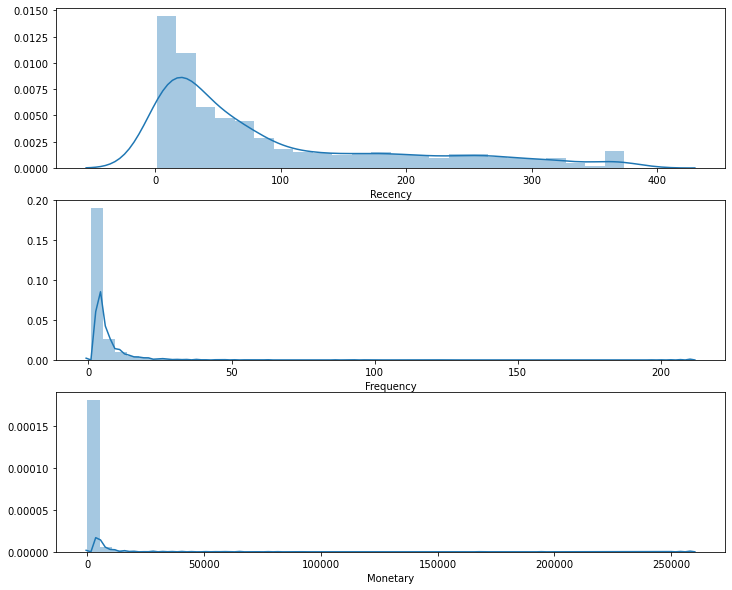

In [33]:
plt.figure(figsize=(12,10))

# Plot distribution of Recency
plt.subplot(3, 1, 1); sns.distplot(rfm_df['Recency'])

# Plot distribution of Frequency
plt.subplot(3, 1, 2); sns.distplot(rfm_df['Frequency'])

# Plot distribution of Monetary value
plt.subplot(3, 1, 3); sns.distplot(rfm_df['Monetary'])

In [34]:
rfm_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,3921.000000,3921.000000,3921.000000
mean,92.722265,4.246111,1857.950687
std,99.528532,7.205750,7477.736186
min,1.000000,1.000000,0.000000
25%,18.000000,1.000000,298.110000
50%,51.000000,2.000000,644.300000
75%,143.000000,5.000000,1570.810000
max,374.000000,210.000000,259657.300000


We see that there are some problems with this data. The distributions are right skewed and variables like monetary have min value zero. Let us treat them.

In [35]:
rfm_df = rfm_df[rfm_df['Monetary'] > 0]
rfm_df.reset_index(drop=True,inplace=True)

raw = rfm_df[['Recency','Frequency','Monetary']]
rfm_log = np.log(raw)

rfm_log

,Recency,Frequency,Monetary
0,5.786897,0.000000,11.253942
1,1.098612,2.397895,8.341889
2,0.000000,5.347108,10.405873
3,1.386294,1.609438,8.316515
4,1.386294,1.386294,6.848366
...,...,...,...
3915,5.627621,0.000000,5.196285
3916,5.198497,0.000000,4.392224
3917,2.079442,0.693147,5.182064
3918,1.386294,2.772589,7.623412


In [36]:
scaler = StandardScaler()
scaler.fit(rfm_log)

final_data = scaler.transform(rfm_log)

# Create a pandas DataFrame
final_rfm = pd.DataFrame(data=final_data, index=raw.index, columns=raw.columns)

final_rfm.head()

,Recency,Frequency,Monetary
0,1.438428,-1.050264,3.779901
1,-1.953555,1.613165,1.446001
2,-2.748403,4.888962,3.100206
3,-1.745416,0.737397,1.425664
4,-1.745416,0.489543,0.248998


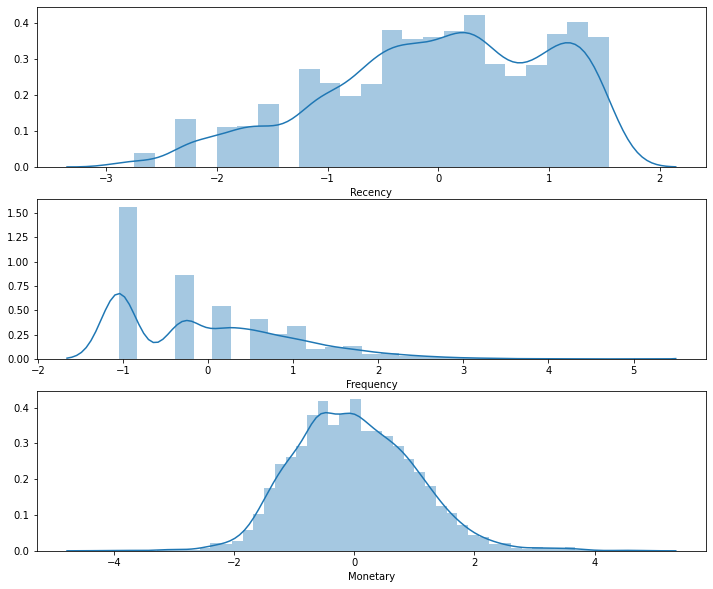

In [37]:
plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(final_rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(final_rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(final_rfm['Monetary'])

# Show the plot
plt.show()

We see that skewness has been removed to a large extent. Let us now built K-means cluster model and find optimal number of clusters.

In [38]:
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(final_rfm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

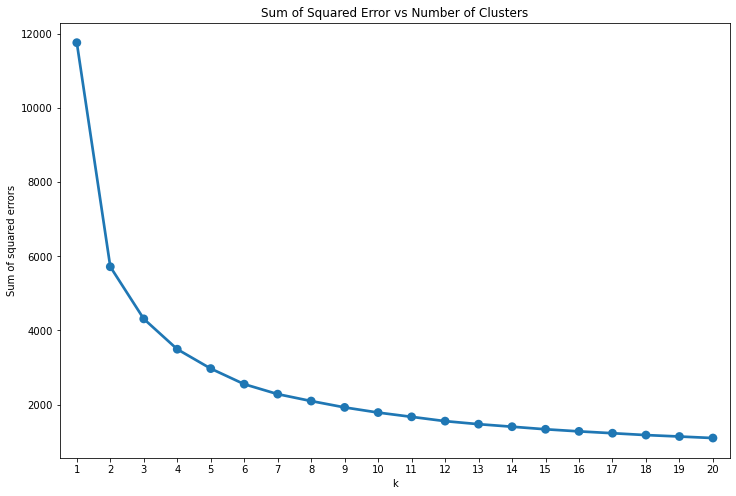

In [39]:
plt.figure(figsize=(12,8))

plt.title('Sum of Squared Error vs Number of Clusters')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

We see that after 4, the decrease starts becoming less steep. Hence we will go with 4 clusters.

Let us check how well the clusters are separated for each variable and try to interpret them.

In [40]:
kmeans = KMeans(n_clusters=4, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(final_rfm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_

In [41]:
final_rfm_k4 = final_rfm.assign(Cluster = cluster_labels)
data_k4 = raw.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k4 = data_k4.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'Monetary': ['mean', 'count'],}).round(0)

summary_k4

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         189.0       1.0    326.0  1378
1          71.0       4.0   1667.0  1120
2          22.0       2.0    464.0   755
3          11.0      13.0   6923.0   667

To interpret this better, let us plot the various mean values for each cluster.

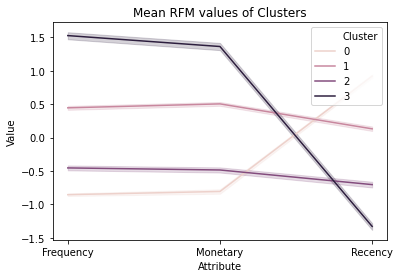

In [42]:
final_rfm_k4.index = rfm_df.index
final_rfm.index.name='CustomerID'

data_melt = pd.melt(final_rfm_k4.reset_index(),
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'Monetary'],
                    var_name='Attribute',
                    value_name='Value')

plt.title('Mean RFM values of Clusters')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt)

We see that the variables have reasonable separation. Let us now try to interpret the clusters based on the graph and clusters summary.
1. Cluster 0 represents lost customers. They have spent the least and very infrequently. Their last transaction was long back.
2. Cluster 1 represents at risk customers who have spent a reasonable amount frequently but whose last transaction was long back.
3. Cluster 2 represents new customers who have transacted very recently and spent a low amount, hence frequency is low
4. Cluster 3 represents the store's best customers. They have transacted most recently and frequently, and have spent the largest amount.




Appropriate strategies can be chosen for each segment of customers.
